In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile
import pathlib
import sklearn
import torchvision
import torch
import random
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from types import SimpleNamespace
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import cv2
import gc
%matplotlib inline

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Mounted at /content/drive


#EuroSAT

In [2]:
transforms = tt.Compose([
                               
                               tt.ToTensor()
])
dataset = torchvision.datasets.EuroSAT(root = "data/", download=True, transform = transforms)
classes = dataset.classes

test_size = 1000
val_size = 1000
train_size = len(dataset) - test_size

batch_size = 256

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting data/eurosat/EuroSAT.zip to data/eurosat
25000 1000 1000


images.shape: torch.Size([256, 3, 64, 64])
tensor([1, 8, 7, 0, 2, 0, 0, 1, 1, 6, 8, 9, 5, 3, 5, 0, 3, 7, 8, 8, 2, 3, 7, 6,
        8, 0, 2, 1, 0, 7, 0, 2, 9, 8, 0, 1, 8, 3, 9, 0, 0, 2, 7, 6, 7, 3, 3, 2,
        1, 7, 7, 5, 5, 0, 8, 7, 7, 2, 6, 4, 3, 3, 1, 0, 9, 9, 0, 9, 6, 3, 0, 4,
        6, 2, 2, 3, 9, 2, 9, 7, 2, 5, 0, 0, 8, 3, 4, 4, 9, 5, 7, 8, 1, 1, 7, 3,
        3, 5, 9, 7, 0, 9, 6, 2, 5, 3, 3, 7, 2, 3, 3, 1, 9, 8, 4, 0, 8, 8, 4, 0,
        4, 1, 6, 7, 3, 4, 0, 2, 4, 6, 1, 2, 8, 5, 0, 0, 7, 9, 8, 7, 6, 7, 9, 9,
        2, 2, 2, 8, 1, 1, 0, 1, 6, 9, 7, 4, 3, 5, 4, 0, 6, 6, 9, 1, 2, 9, 7, 0,
        3, 1, 0, 7, 3, 7, 7, 1, 0, 4, 0, 9, 0, 1, 4, 7, 9, 2, 9, 0, 6, 6, 7, 1,
        7, 1, 9, 6, 4, 3, 2, 2, 9, 9, 9, 1, 7, 5, 1, 9, 0, 5, 5, 5, 0, 7, 0, 0,
        2, 9, 2, 0, 3, 9, 8, 9, 2, 4, 9, 3, 7, 8, 7, 7, 9, 5, 0, 8, 9, 6, 8, 4,
        5, 2, 0, 2, 8, 6, 4, 6, 9, 9, 1, 7, 6, 5, 2, 4])


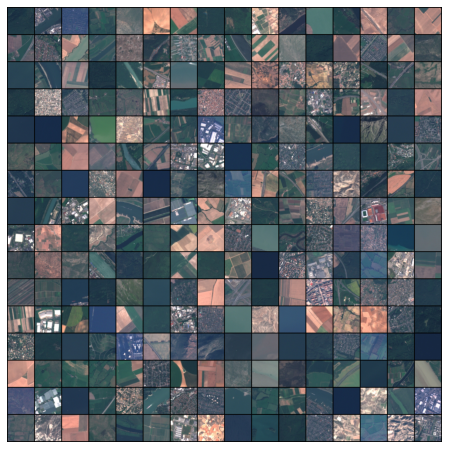

In [3]:
for images, targets in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    print(targets)
    break

#Assets

In [4]:
def get_mean_and_std(data_loader):
  mean = 0
  std = 0
  images_count = 0
  for images, _ in data_loader:
    
    images_in_the_batch = images.size(0)
    images = images.view(images_in_the_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    images_count += images_in_the_batch
  
  mean /= images_count
  std /= images_count
  
  return mean, std

In [5]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    print("accuracy = ", num_correct/num_samples)
    return num_correct/num_samples

class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

def conv_block(in_channels, out_channels, pool=False):
    layers = [SeparableConv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)




In [22]:
def train_with_distillation(train_loader, test_loader, model, loss_fn, optimizer, teacher_model, max_lr, epochs, alpha = 0.1, temperature = 3):
    # alpha = 0.4
    # temperature = 3
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                            steps_per_epoch=len(train_loader))
    
    sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)
    teacher_model.eval()
    for epoch in range(epochs):
      model.train()
      for data, targets in tqdm(train_loader):
          data = data.to(DEVICE)
          targets = targets.to(DEVICE)

          scores = model(data)
          teacher_model_scores = teacher_model(data)
          teacher_prob = F.softmax(teacher_model_scores/temperature, dim=1)
          student_prob = F.softmax(scores/temperature, dim=1)
          dist_loss = F.kl_div(student_prob, teacher_prob)
          loss = alpha * loss_fn(scores, targets) + (1 - alpha) * dist_loss

          
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          # sched.step()
      sched.step()
      check_accuracy(test_loader, model, DEVICE)

def simple_train(train_loader, test_loader, model, loss_fn, optimizer, max_lr, epochs):
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                            steps_per_epoch=len(train_loader))
    sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)
    teacher_model.eval()
    for epoch in range(epochs):
      model.train()
      for data, targets in tqdm(train_loader):
          data = data.to(DEVICE)
          targets = targets.to(DEVICE)

          scores = model(data)
          loss = loss_fn(scores, targets)

          
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          # sched.step()
      sched.step()
      check_accuracy(test_loader, model, DEVICE)

def train_one_epoch(loader, model, loss_fn, optimizer):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        scores = model(data)
        loss = loss_fn(scores, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

#MyModel

In [51]:
class MyNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.transition1 = SqueezeExcitation(64, 32)
        
        self.conv3 = conv_block(64, 256, pool=True)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.transition2 = SqueezeExcitation(256, 128)

        self.conv5 = conv_block(256, 512, pool=True)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes)
                                        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.transition1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.transition2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out

        out = self.classifier(out)
        return out

In [52]:
class SmallMyNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 16)
        self.conv2 = conv_block(16, 32, pool=True)
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))

        self.transition1 = SqueezeExcitation(32, 16)
        
        self.conv3 = conv_block(32, 64, pool=True)
        self.conv4 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.transition2 = SqueezeExcitation(64, 32)

        self.conv5 = conv_block(64, 128, pool=True)
        self.conv6 = conv_block(128, 128, pool=True)
        self.res3 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(128, num_classes)
                                        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.transition1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.transition2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out

        out = self.classifier(out)
        return out

In [53]:
MyModel = SmallMyNet()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MyModel = MyModel.to(DEVICE)
pytorch_total_params = sum(p.numel() for p in MyModel.parameters() if p.requires_grad)
print(pytorch_total_params)

89397


#Teacher model

In [12]:
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
teacher_model.fc = nn.Linear(2048, 10)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
teacher_model = teacher_model.to(DEVICE)
pytorch_total_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(pytorch_total_params)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

42520650


In [16]:
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-5
NUM_EPOCHS = 1

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
        teacher_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

In [17]:
simple_train(train_loader, val_loader, teacher_model, loss_fn, optimizer, LEARNING_RATE, NUM_EPOCHS)

100%|██████████| 98/98 [00:45<00:00,  2.15it/s]


accuracy =  tensor(0.9810, device='cuda:0')


In [18]:
check_accuracy(test_loader, teacher_model, DEVICE)

accuracy =  tensor(0.9770, device='cuda:0')


tensor(0.9770, device='cuda:0')

In [58]:
torch.save(teacher_model, "/content/drive/MyDrive/MyModels/EuroSAT_ResNet101_val_acc=0,983_test_acc=0,977")

#Distillation training

In [96]:
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-2
NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
        MyModel.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

In [55]:
gc.collect()
torch.cuda.empty_cache()

In [56]:
train_with_distillation(train_loader, val_loader, MyModel, loss_fn, optimizer, teacher_model,
                        LEARNING_RATE, NUM_EPOCHS, alpha = 0.4, temperature = 1)

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 98/98 [00:49<00:00,  1.97it/s]


accuracy =  tensor(0.6260, device='cuda:0')


100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


accuracy =  tensor(0.8720, device='cuda:0')


100%|██████████| 98/98 [00:49<00:00,  1.99it/s]


accuracy =  tensor(0.8900, device='cuda:0')


100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


accuracy =  tensor(0.9130, device='cuda:0')


100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


accuracy =  tensor(0.9360, device='cuda:0')


In [57]:
check_accuracy(test_loader, MyModel, DEVICE)

accuracy =  tensor(0.9280, device='cuda:0')


tensor(0.9280, device='cuda:0')

In [59]:
torch.save(MyModel, "/content/drive/MyDrive/MyModels/EuroSAT_SmallMyNet_val_acc=0,936_test_acc=0,928")

#Training without distillation

In [101]:
MyModel_noDistil = SmallMyNet()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MyModel_noDistil = MyModel_noDistil.to(DEVICE)
pytorch_total_params = sum(p.numel() for p in MyModel_noDistil.parameters() if p.requires_grad)
print(pytorch_total_params)

89397


In [102]:
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-2
NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
        MyModel_noDistil.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

In [103]:
simple_train(train_loader, val_loader, MyModel_noDistil, loss_fn, optimizer, LEARNING_RATE, NUM_EPOCHS)

100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


accuracy =  tensor(0.4930, device='cuda:0')


100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


accuracy =  tensor(0.7840, device='cuda:0')


100%|██████████| 98/98 [00:10<00:00,  9.71it/s]


accuracy =  tensor(0.9160, device='cuda:0')


100%|██████████| 98/98 [00:10<00:00,  9.75it/s]


accuracy =  tensor(0.9190, device='cuda:0')


100%|██████████| 98/98 [00:10<00:00,  9.58it/s]


accuracy =  tensor(0.9200, device='cuda:0')


In [104]:
check_accuracy(test_loader, MyModel_noDistil, DEVICE)

accuracy =  tensor(0.9080, device='cuda:0')


tensor(0.9080, device='cuda:0')

In [105]:
torch.save(MyModel_noDistil, "/content/drive/MyDrive/MyModels/EuroSAT_SmallMyNetNoDistillation_val_acc=0,920_test_acc=0,908")

#Test

In [106]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(DEVICE)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    pred  = torch.argmax(yb)
    # Retrieve the class label
    return classes[pred.item()]

In [107]:
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Label: PermanentCrop , Predicted: PermanentCrop


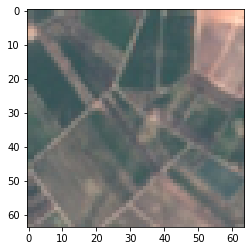

In [127]:
MyModel.eval()
img, label = test_dataset[-1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, MyModel))